In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import make_scorer
import sklearn.metrics as metrics
from sklearn.dummy import DummyRegressor

In [67]:
def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred) 
    mse = metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error = metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    
    print('explained_variance: ', round(explained_variance, 4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error, 4))
    print('r2: ', round(r2, 4))
    print('MAE: ', round(mean_absolute_error, 4))
    print('MSE: ', round(mse, 4))
    print('RMSE: ', round(np.sqrt(mse), 4))

In [68]:
df = pd.read_csv('data/final/soja_cepea_final.csv')
df['data'] = pd.to_datetime(df['data'])
df = df.set_index('data')

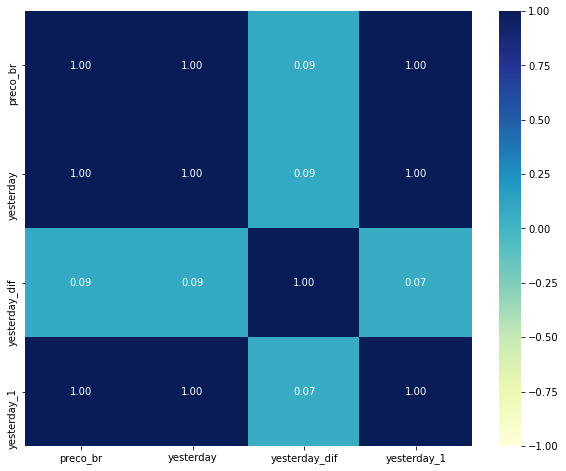

In [69]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), cmap='YlGnBu', annot=True, fmt='.2f', vmin=-1);

In [70]:
X_train = df [:'2019'].drop (['preco_br'], axis = 1)
y_train = df.loc [:'2019', 'preco_br']
X_test = df['2020'].drop (['preco_br'], axis = 1)
y_test = df.loc ['2020', 'preco_br']

## Check Models

LR: 0.978503 (0.017776)
NN: 0.974517 (0.023519)
KNN: 0.813634 (0.377456)
RF: 0.804625 (0.373711)
SVR: -1.616081 (4.057741)
Dummy: -27.897795 (30.802449)
DTR: 0.791481 (0.361534)
AdaBR: 0.794221 (0.398992)


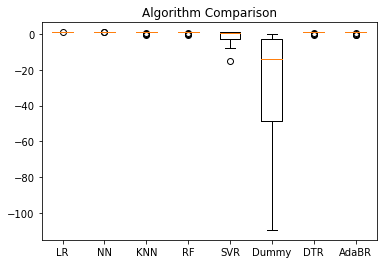

In [71]:
models = []
models.append(('LR', LinearRegression()))
models.append(('NN', MLPRegressor(random_state=1, max_iter=500)))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
models.append(('Dummy', DummyRegressor()))
models.append(('DTR', DecisionTreeRegressor(random_state=0)))
models.append(('AdaBR',  AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=np.random.RandomState(1))))
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
    tscv = TimeSeriesSplit(n_splits=len(df.index.year.unique()) - 1)
    
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
    results.append(cv_results)
    names.append(name)
    print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()

In [72]:
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score
rmse_score = make_scorer(rmse, greater_is_better = False)

In [73]:
model = LinearRegression()
parameters = {
    'fit_intercept': [True, False], 
    'normalize': [True, False], 
    'copy_X': [True, False],
}

tscv = TimeSeriesSplit(n_splits = len(df.index.year.unique()) - 1)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid = parameters, scoring = rmse_score)
gsearch.fit(X_train, y_train)

best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
y_true = y_test
y_pred = best_model.predict(X_test)

regression_results(y_true, y_pred)

explained_variance:  0.9986
mean_squared_log_error:  0.0001
r2:  0.9986
MAE:  0.7922
MSE:  1.1334
RMSE:  1.0646


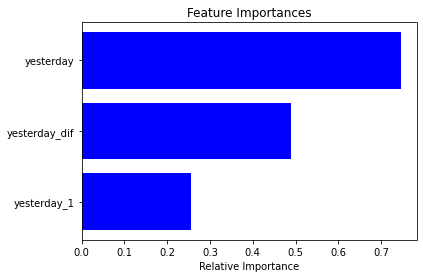

In [74]:
imp = best_model.coef_
features = X_train.columns
indices = np.argsort(imp)
plt.title('Feature Importances')
plt.barh(range(len(indices)), imp[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [75]:
d = {'Real': y_true, 'Previsto': y_pred}
df_results = pd.DataFrame(data=d)

In [76]:
df_results

,Real,Previsto
data,,
2020-01-02,82.71,83.145505
2020-01-03,82.80,82.634988
2020-01-06,82.92,82.830801
2020-01-07,83.01,82.957869
2020-01-08,82.83,83.040826
...,...,...
2020-12-22,141.00,142.167078
2020-12-23,141.59,140.762490
2020-12-28,141.53,141.745205


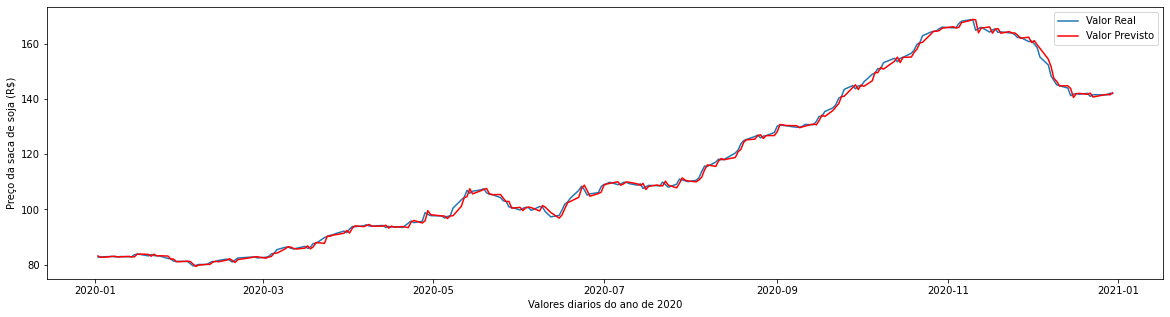

In [77]:
# Start and end of the date range to extract
start, end = '2020-01', '2020-12'
# Plot daily and weekly resampled time series together
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df_results.loc[start:end, 'Real'], linestyle='-', linewidth=1.5, label='Valor Real')
ax.plot(df_results.loc[start:end, 'Previsto'], linestyle='-', linewidth=1.5, color='r', label='Valor Previsto')
ax.set_ylabel('Preço da saca de soja (R$)')
ax.set_xlabel('Valores diarios do ano de 2020')
ax.legend();

### Salvando modelo

In [78]:
filename = 'trained_models/soy_quotation_lr.sav'
pickle.dump(best_model, open(filename, 'wb'))